In [221]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
from transformers import AutoModelForCausalLM, AutoTokenizer

from core.utils.device import DEVICE
from core.utils.theme import set_theme

set_theme()

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B")
model.to(DEVICE)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B")

# EN-RU


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  100


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Data len:  100


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


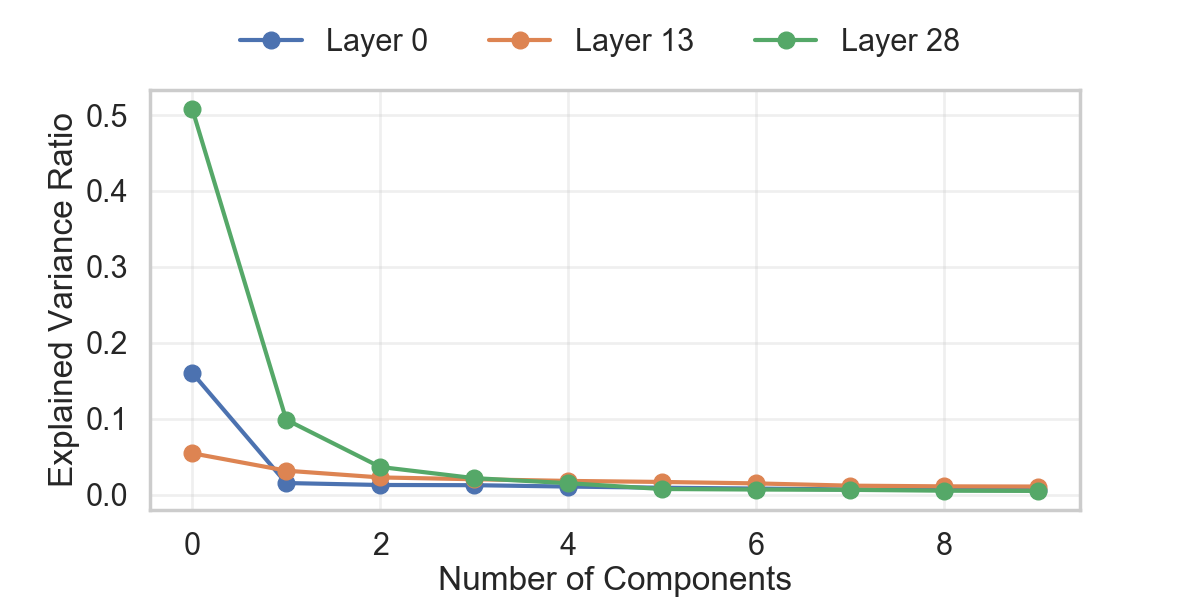

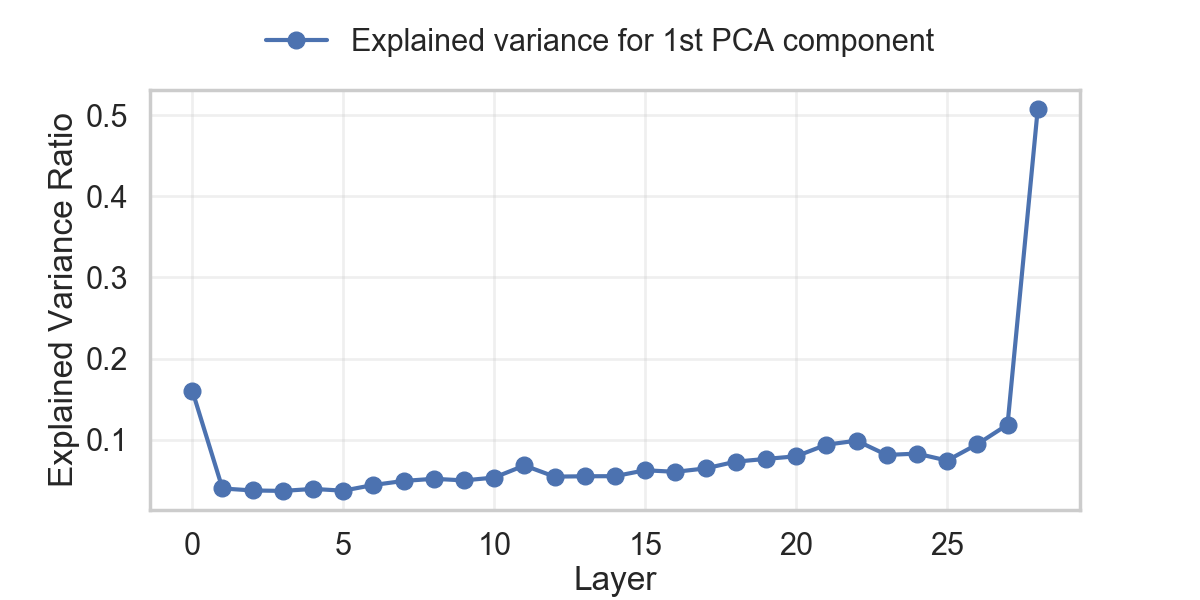

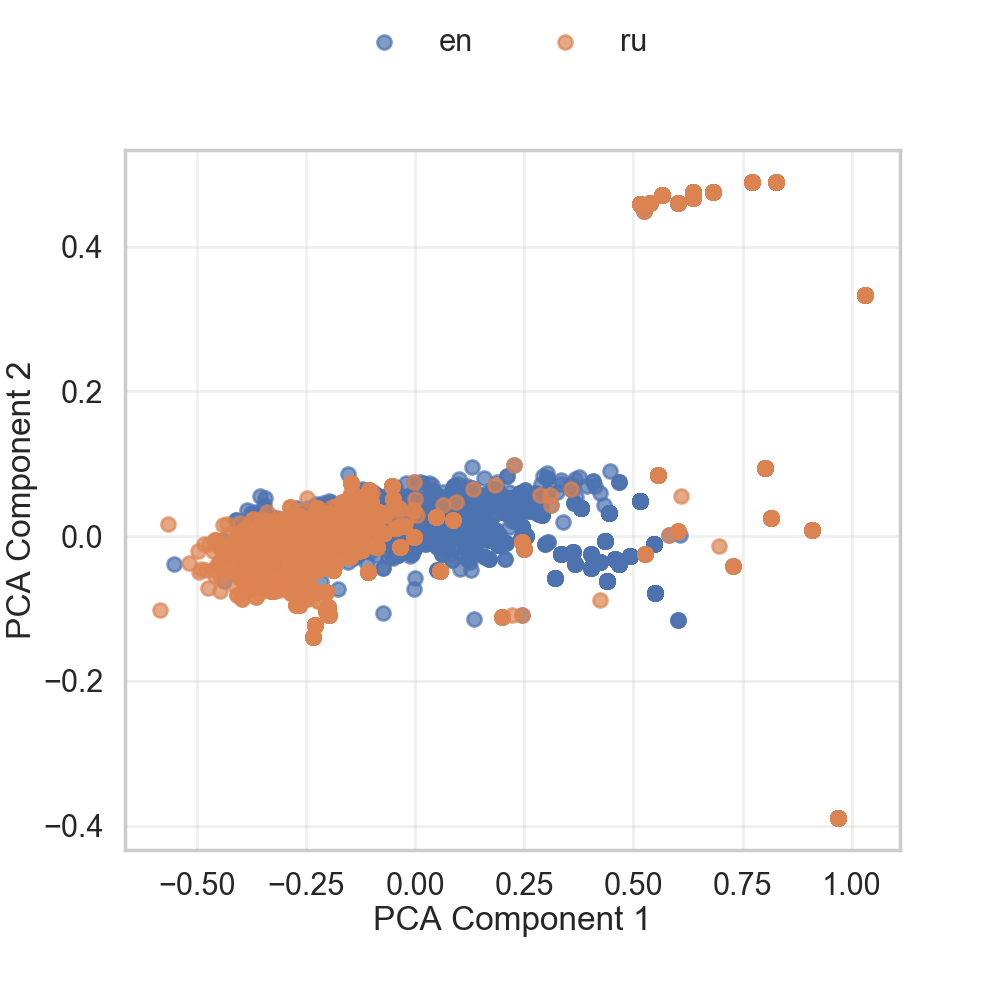

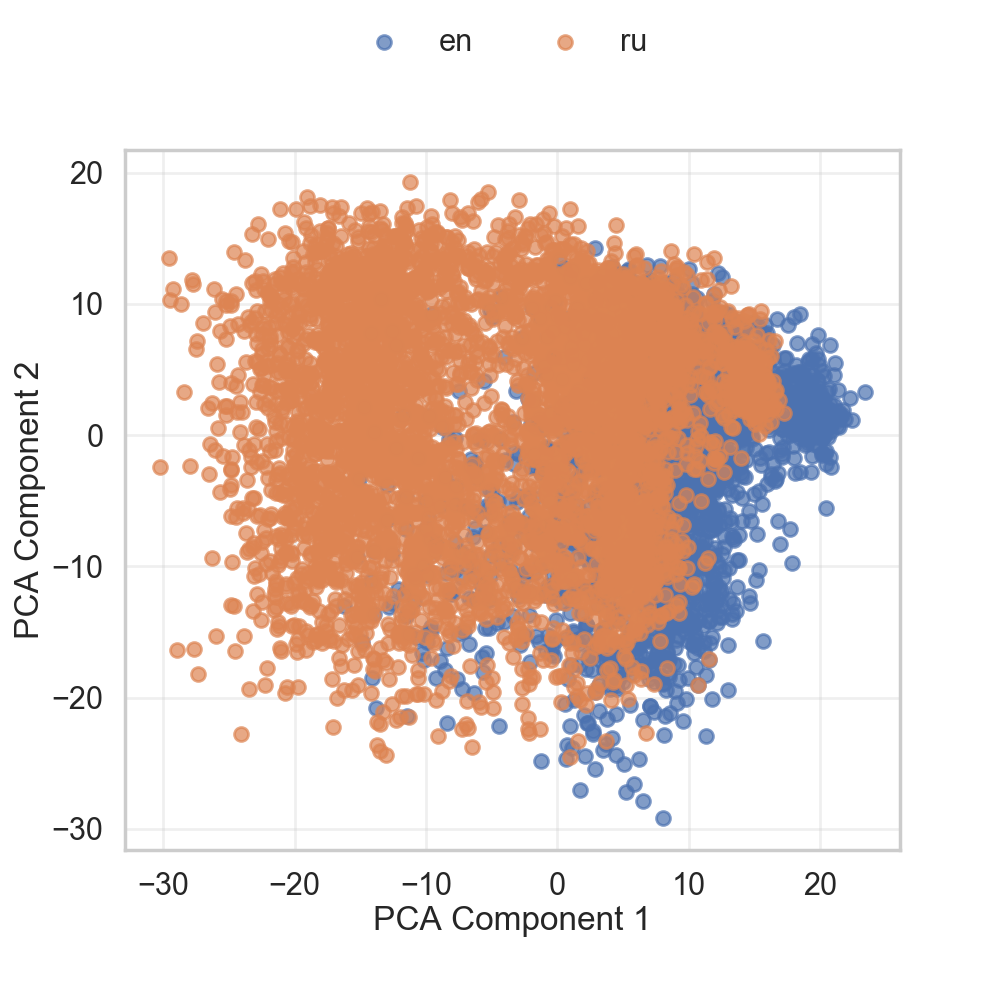

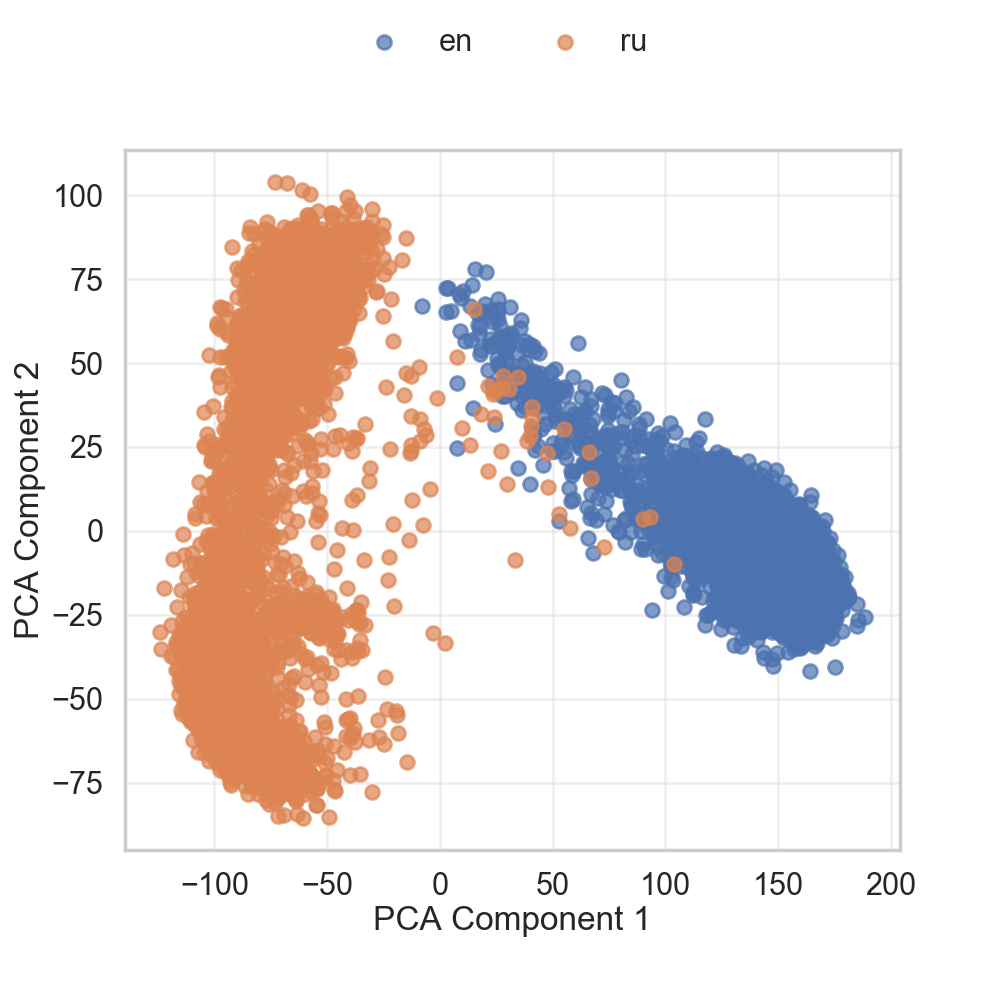

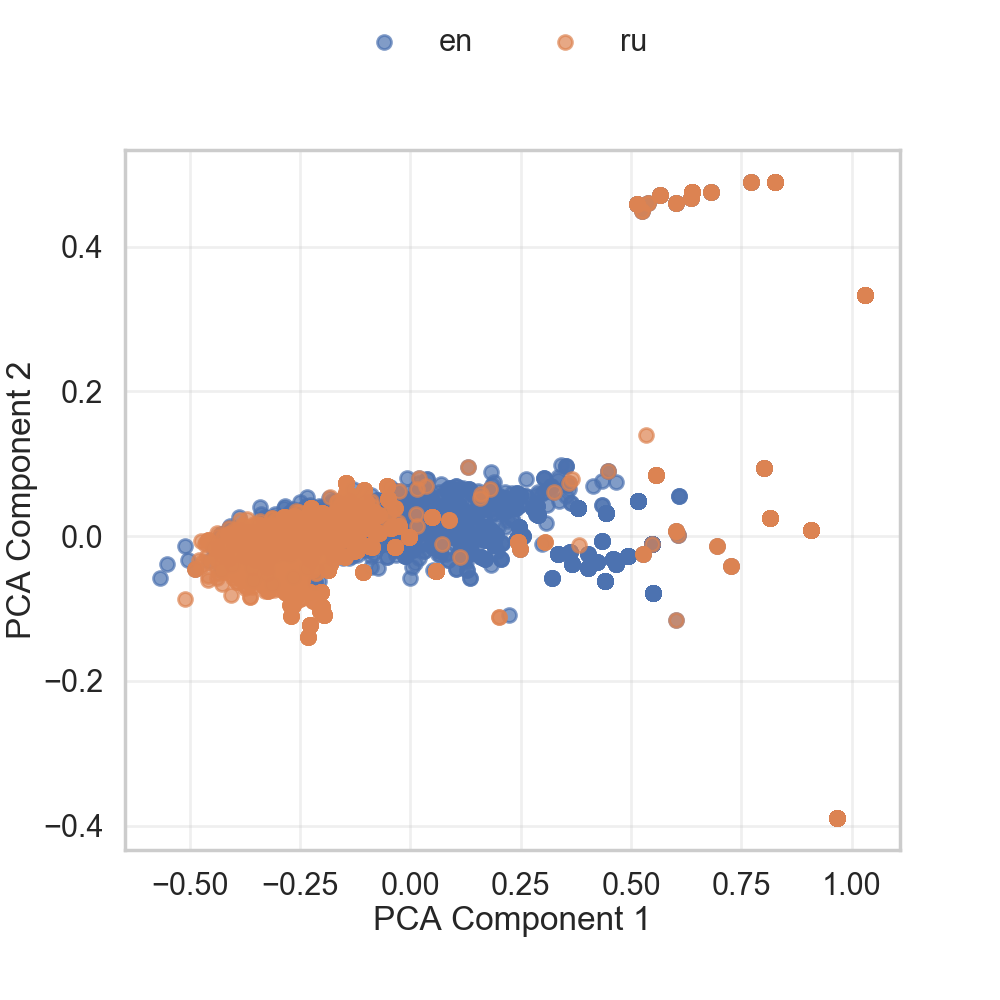

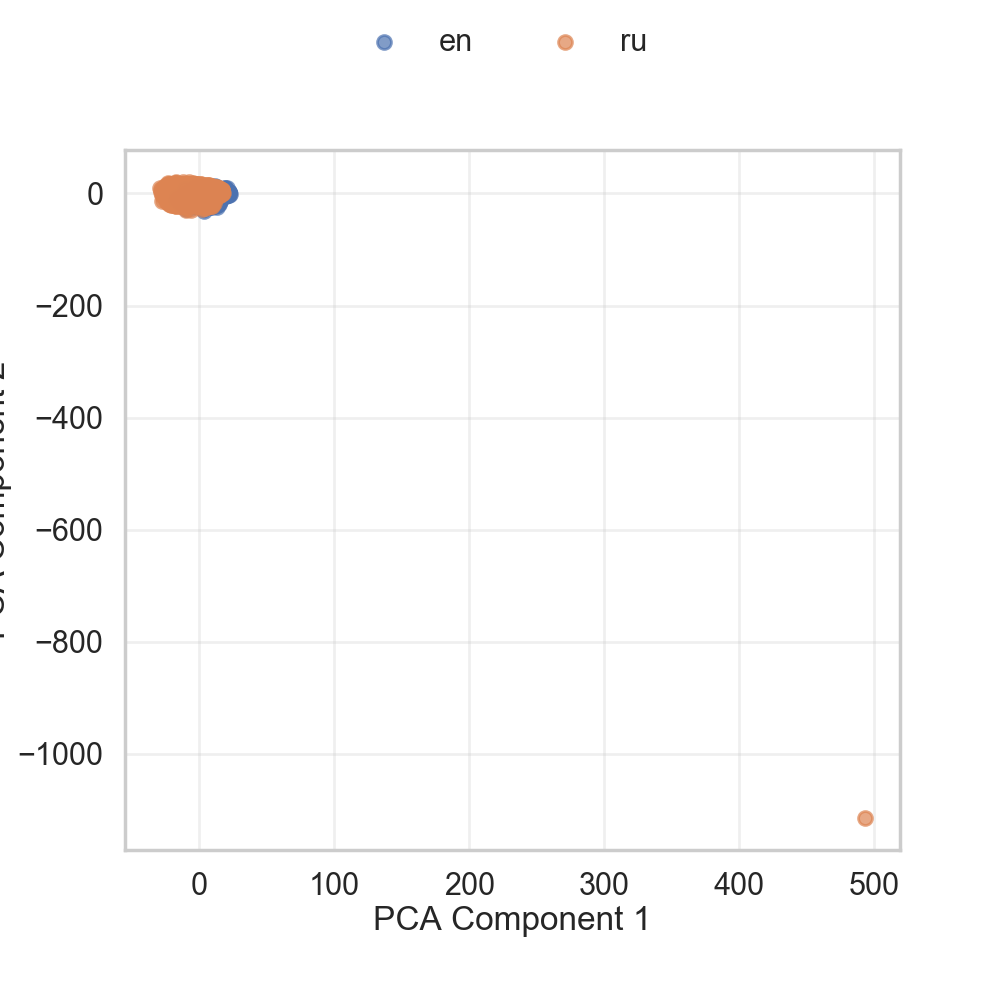

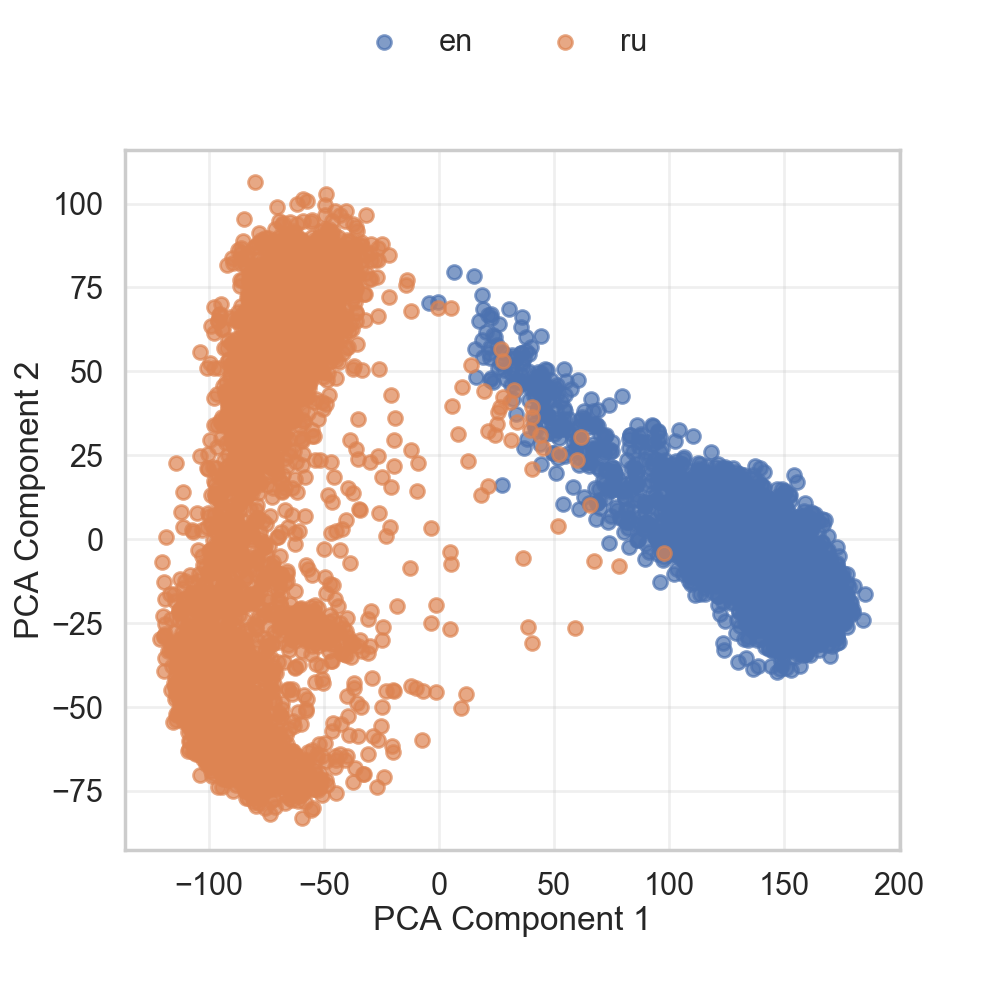

In [223]:
from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.steering.pca import PCASteering
from core.visualize.visualize_explained_variance import visualize_explained_variance
from core.visualize.visualize_projections import visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "rus_Cyrl"], {"eng_Latn": "en", "rus_Cyrl": "ru"}, train_size=100)

test_df = test_df[:100]

hidden_space_by_language_train, token_map_for_language_train = collect_hidden_space_by_language(
    model, tokenizer, train_df, skip_first=True
)
hidden_space_by_language_test, token_map_for_language_test = collect_hidden_space_by_language(
    model, tokenizer, test_df, skip_first=True
)

pca_steering = PCASteering().fit(hidden_space_by_language_train)
visualize_explained_variance(pca_steering.explained_variance_ratios)

projections_train = pca_steering.project(hidden_space_by_language_train)
visualize_projections(hidden_space_by_language_train, token_map_for_language_train, projections_train, tokenizer)

projections_test = pca_steering.project(hidden_space_by_language_test)
visualize_projections(hidden_space_by_language_test, token_map_for_language_test, projections_test, tokenizer)

In [224]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

In [225]:
model.model.layers

ModuleList(
  (0-27): 28 x Qwen2DecoderLayer(
    (self_attn): Qwen2Attention(
      (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
      (k_proj): Linear(in_features=1536, out_features=256, bias=True)
      (v_proj): Linear(in_features=1536, out_features=256, bias=True)
      (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
    )
    (mlp): Qwen2MLP(
      (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
      (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
      (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
  )
)

In [226]:
from core.integration.SteeredQwen2DecoderLayer import SteeredQwen2DecoderLayer

replacement_layers = []
for index in [26, 27]:
    replacement_layer = SteeredQwen2DecoderLayer(model.config, index, pca_steering).to(model.device)
    original_layer = model.model.layers[index]
    replacement_layer.load_state_dict(original_layer.state_dict())
    model.model.layers[index] = replacement_layer
    replacement_layers.append(replacement_layer)

In [234]:
import torch

replacement_layers[0].set_steering_direction(0)
replacement_layers[1].set_steering_direction(-2)

inputs = tokenizer(["Hello "], return_tensors="pt", add_special_tokens=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    generated = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

print(tokenizer.decode(generated[0], skip_special_tokens=True))

for replacement_layer in replacement_layers:
    replacement_layer.reset()

Hello  идиоты, я новичок в php, и вот я хочу сделать так, чтобы при нажатии на кнопку, появлялся блок с текстом, но при этом, если я нажму на кноп


# EN-CN


In [198]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "cmn_Hans"], {"eng_Latn": "en", "cmn_Hans": "cn"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)

ModuleNotFoundError: No module named 'core.visualize.process_hidden_space'

# EN-ES


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:04<00:00, 10.68it/s]


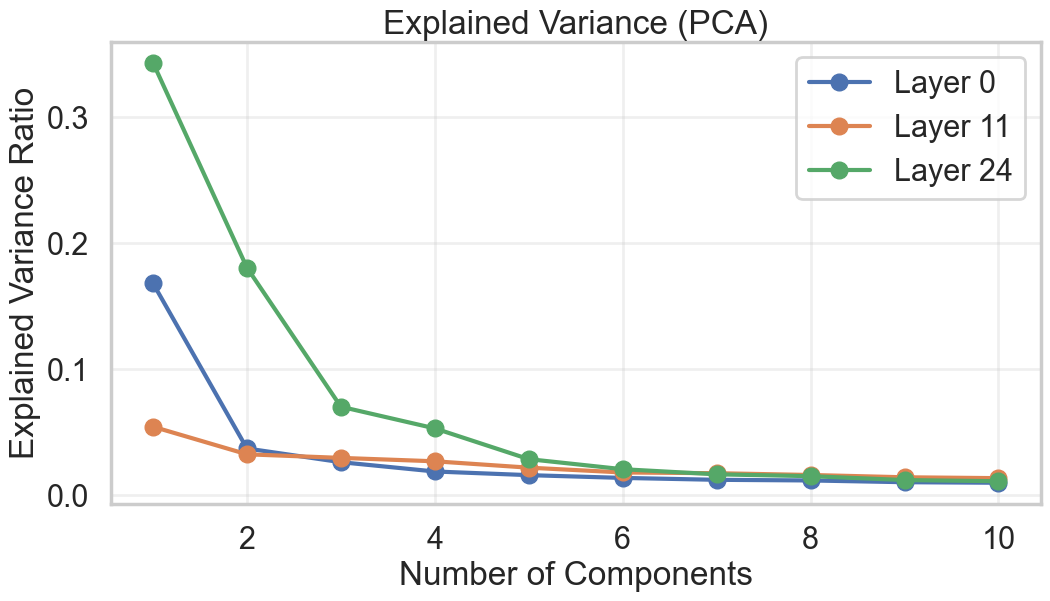

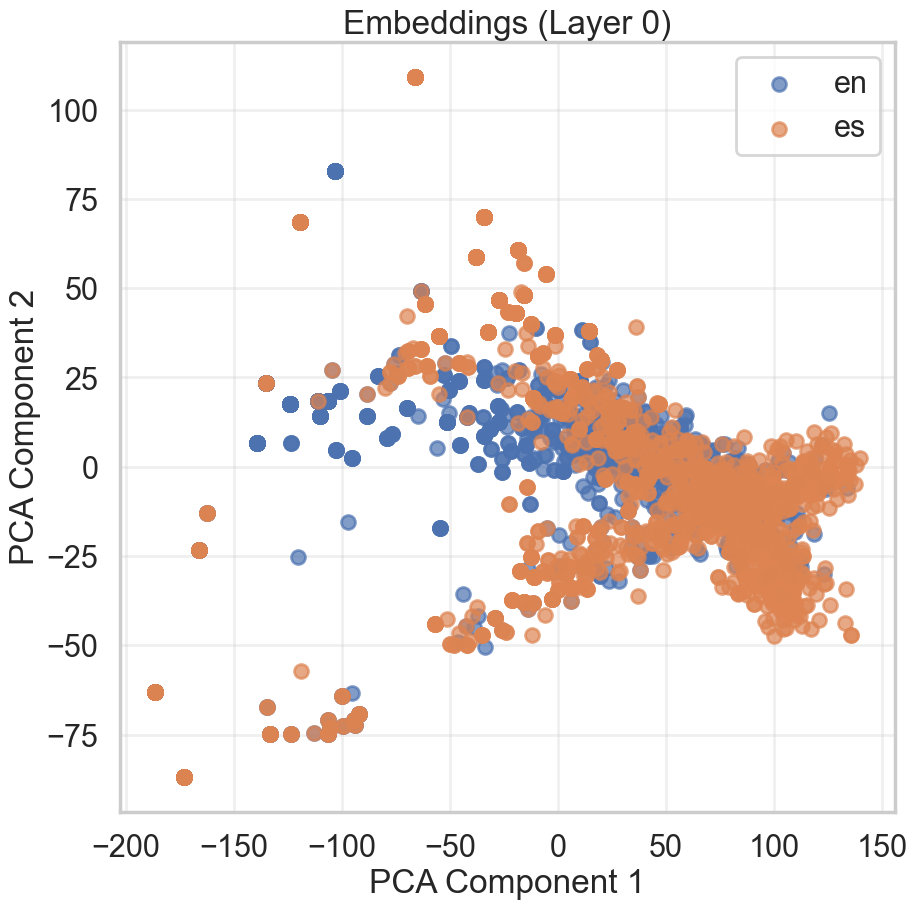

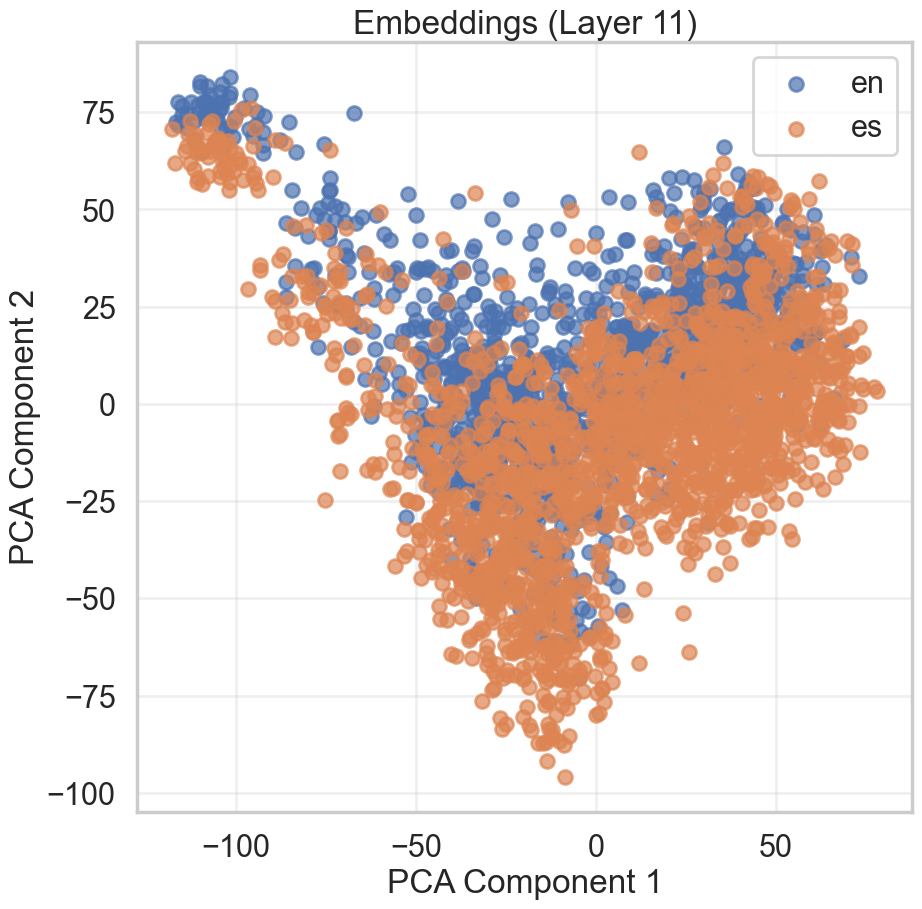

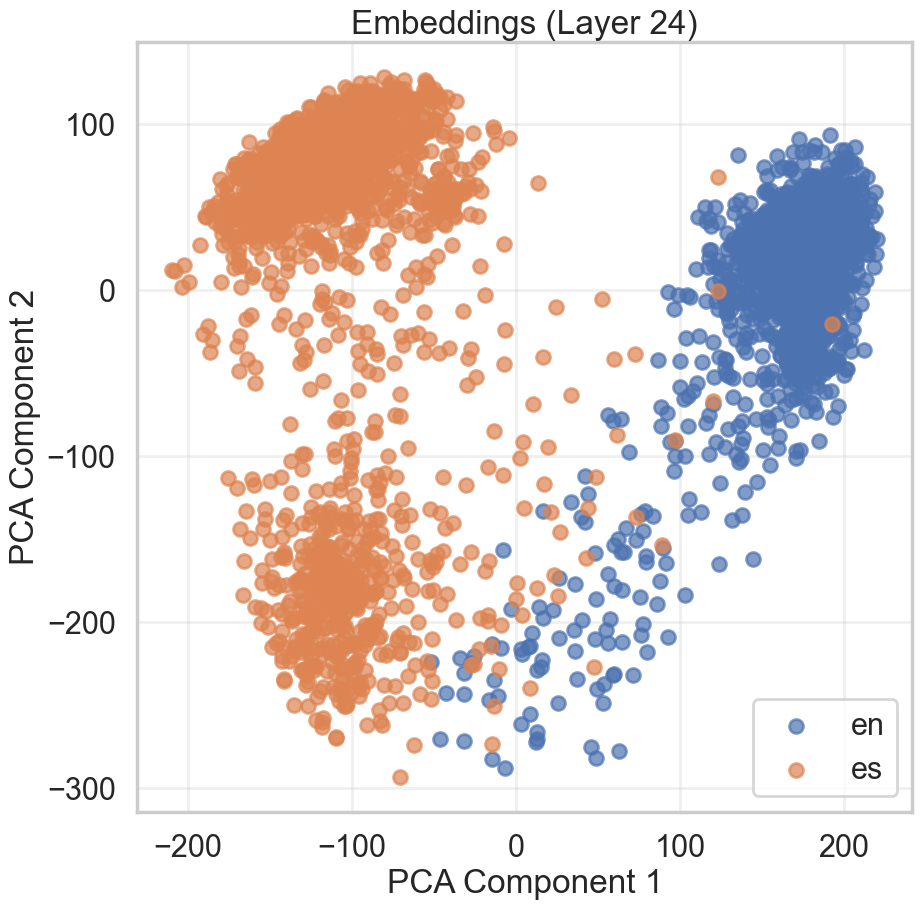

Data len:  100


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


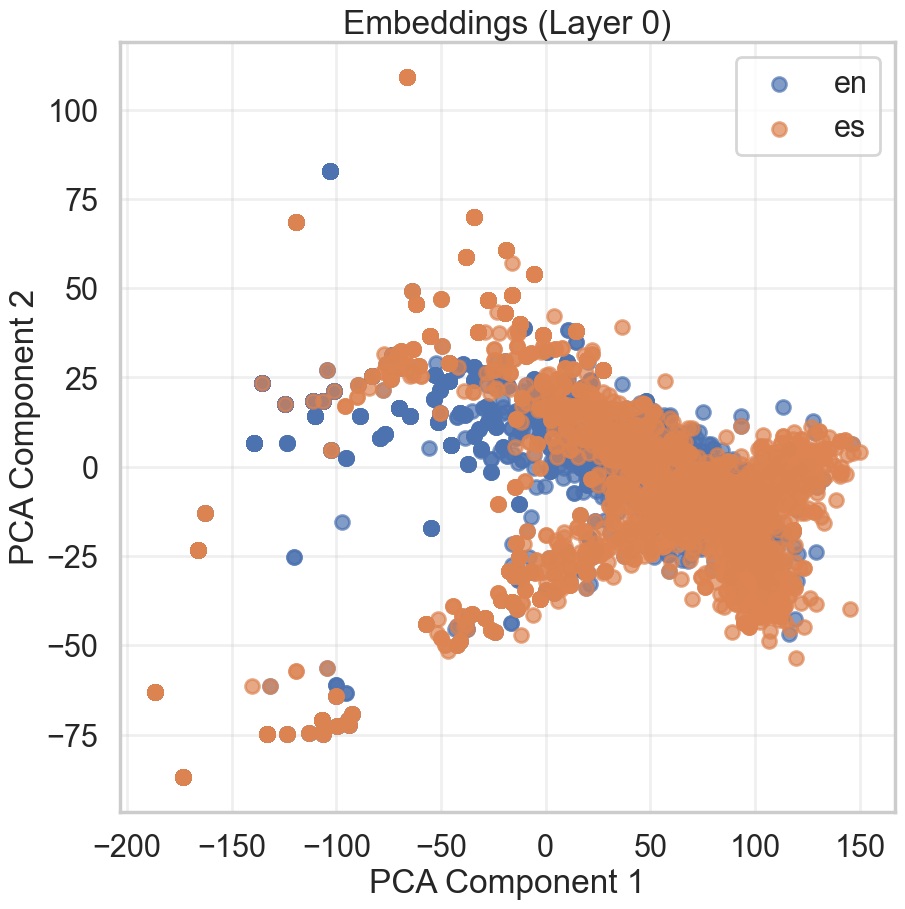

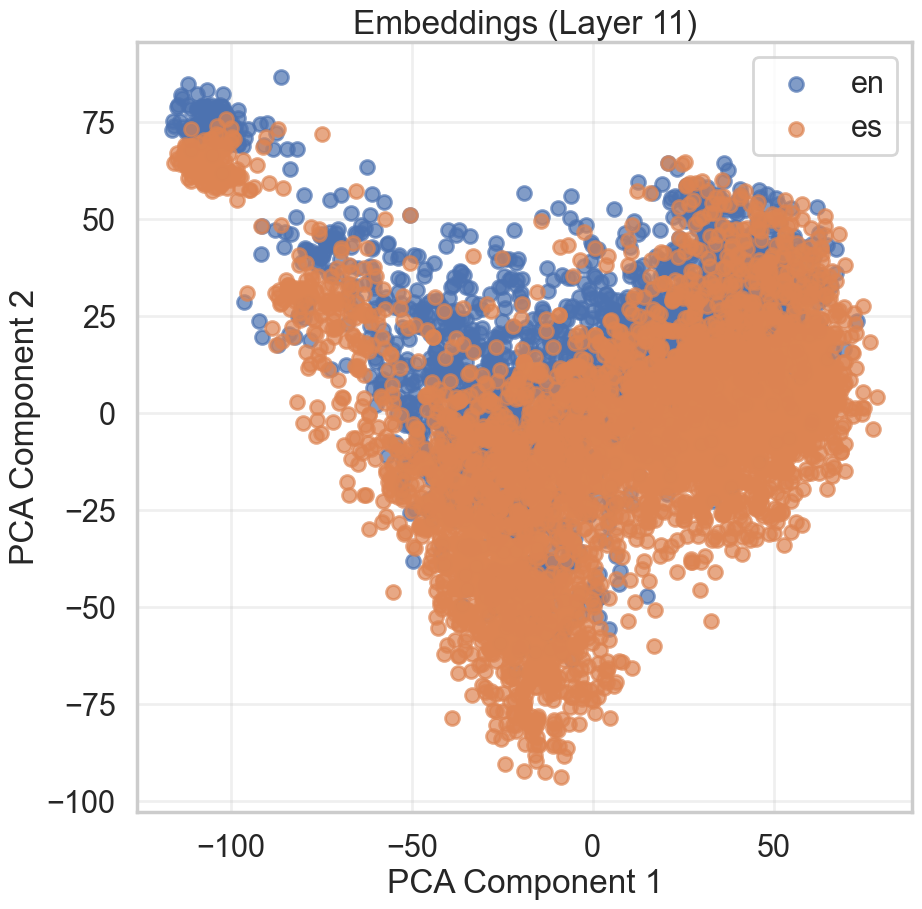

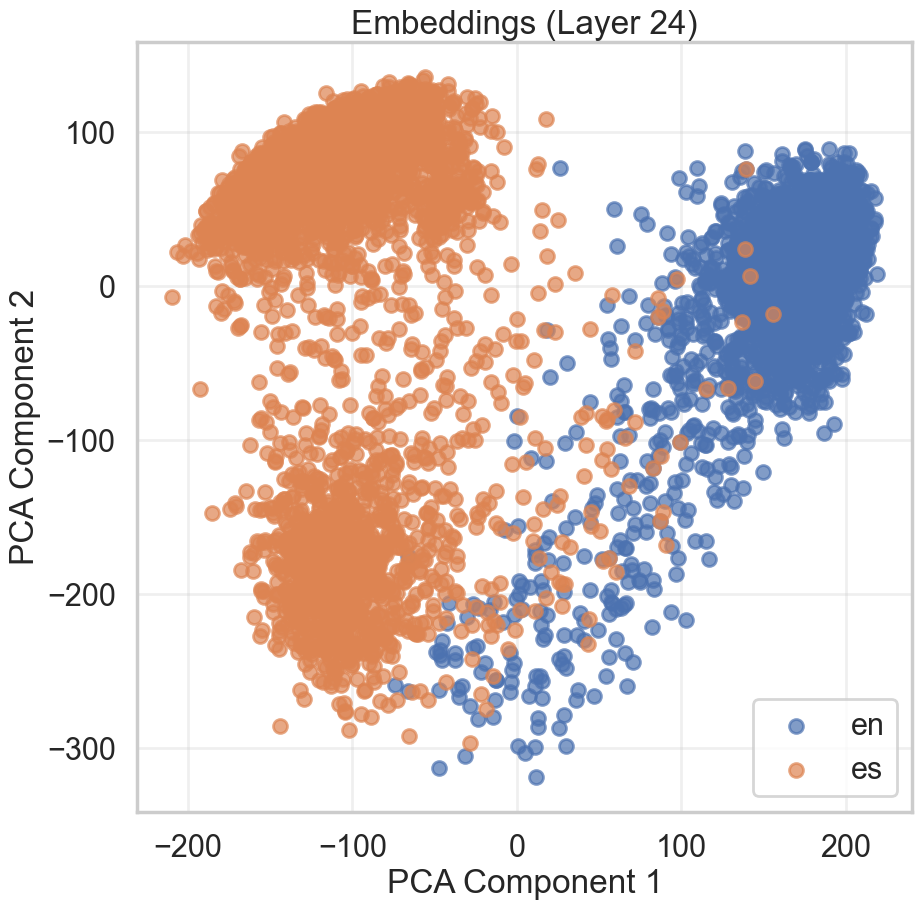

In [ ]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "spa_Latn"], {"eng_Latn": "en", "spa_Latn": "es"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)

# EN-Arab


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


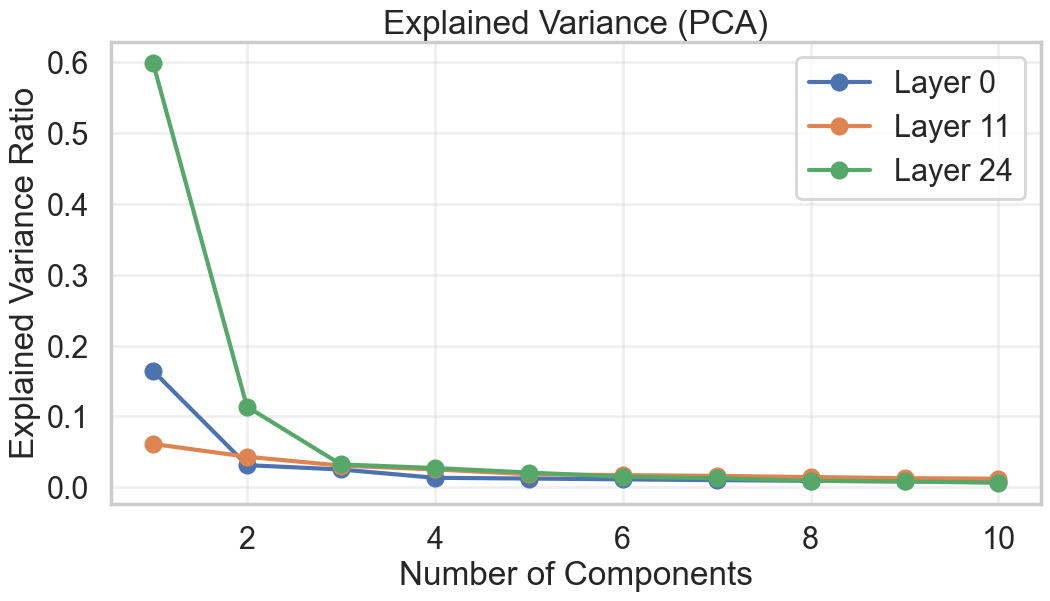

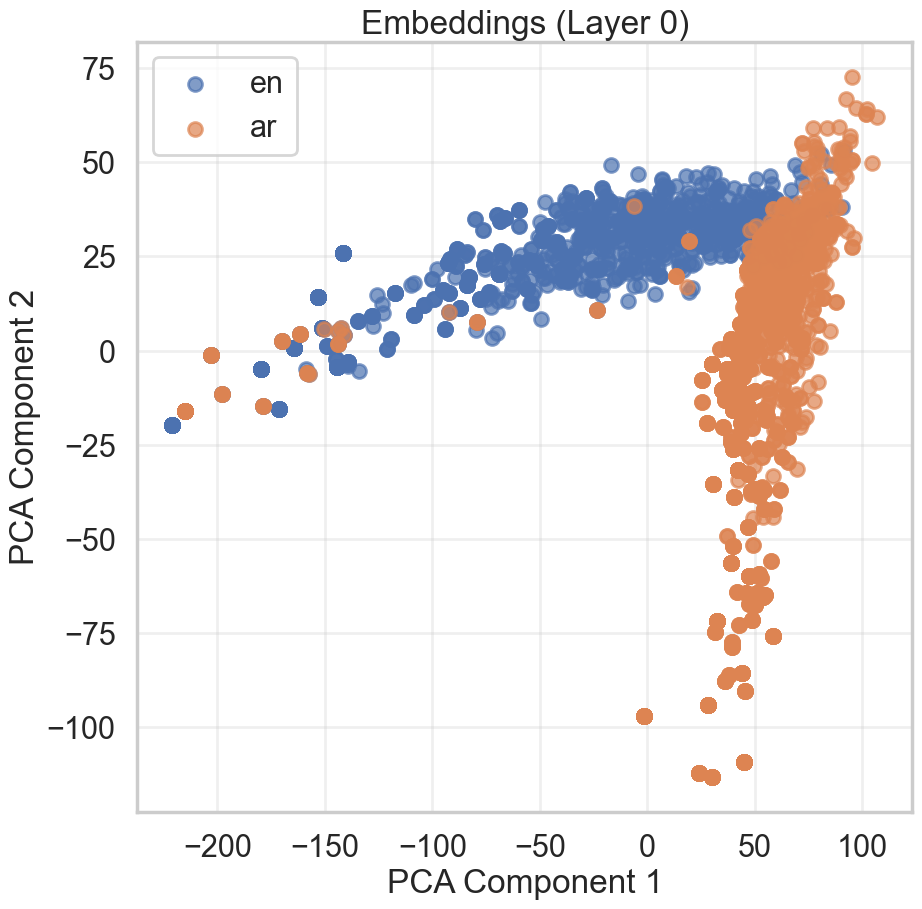

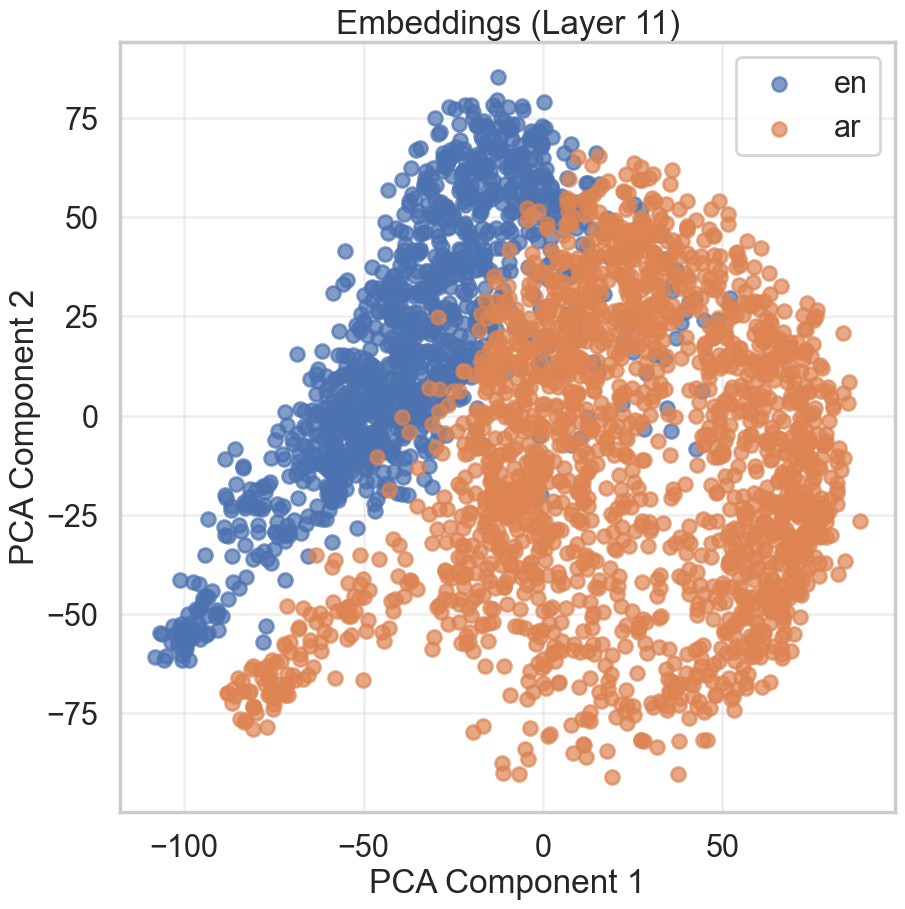

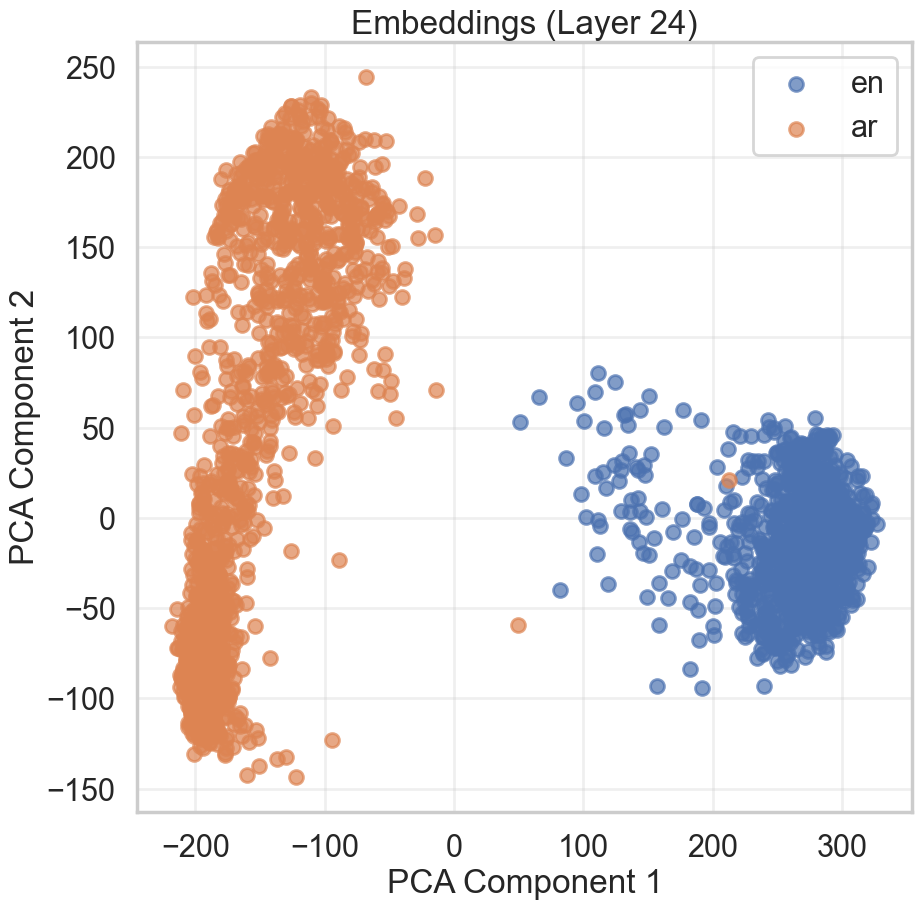

Data len:  100


100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


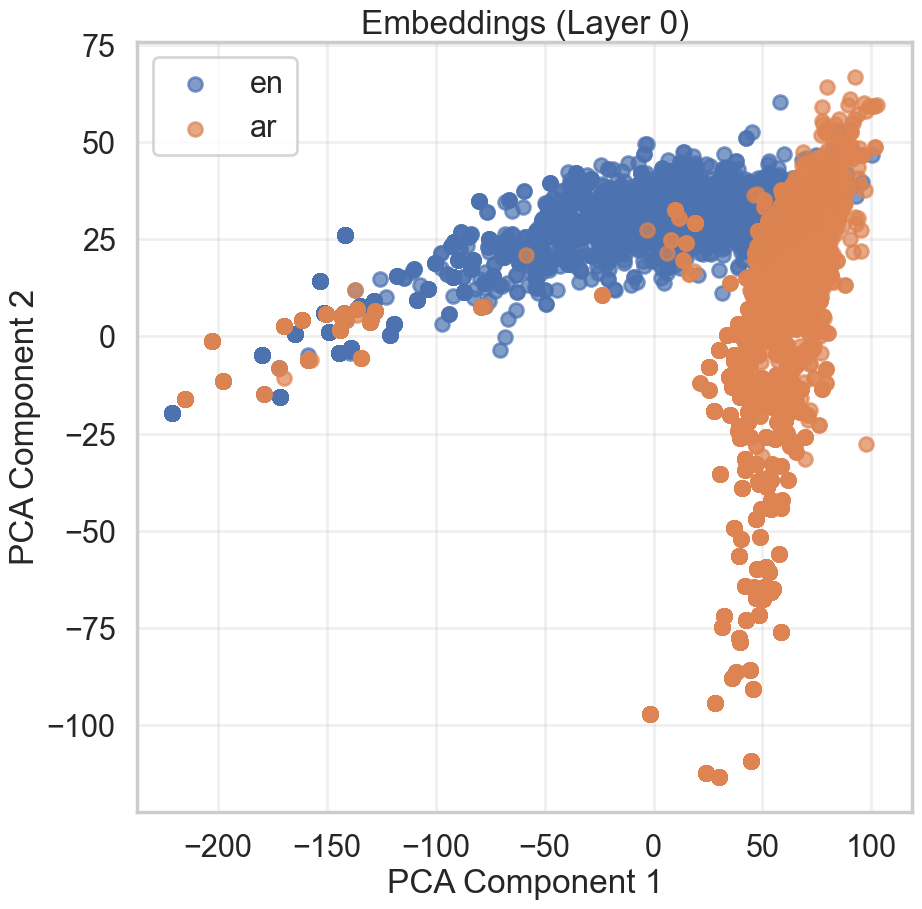

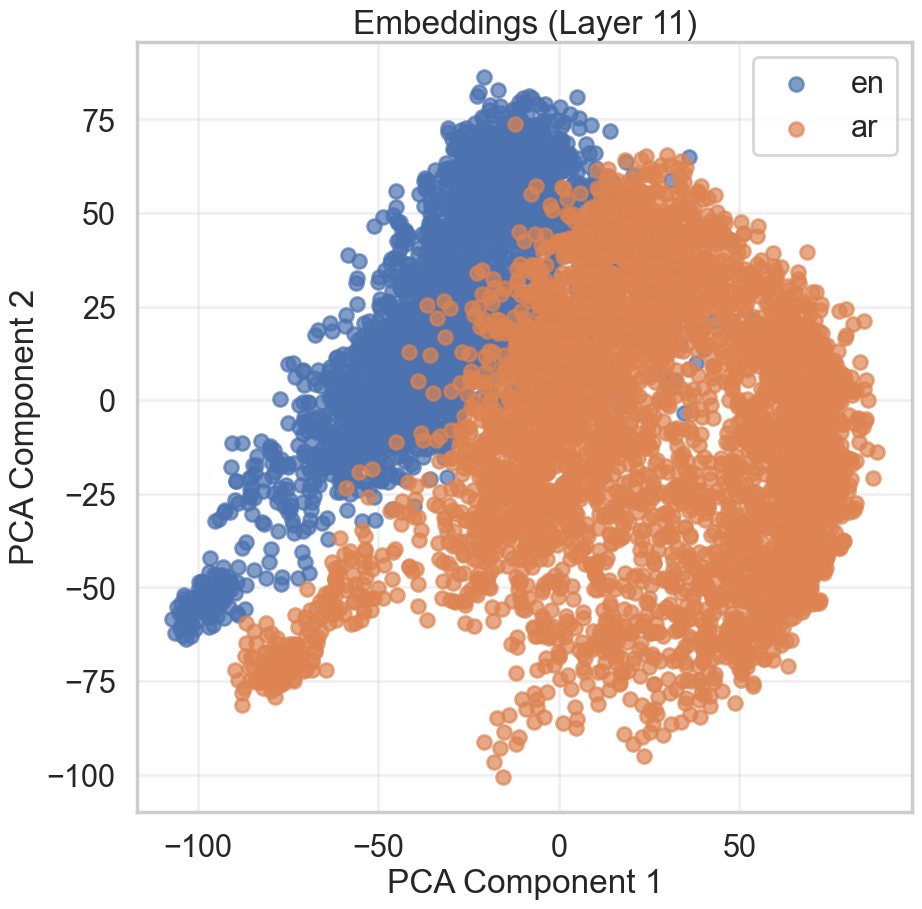

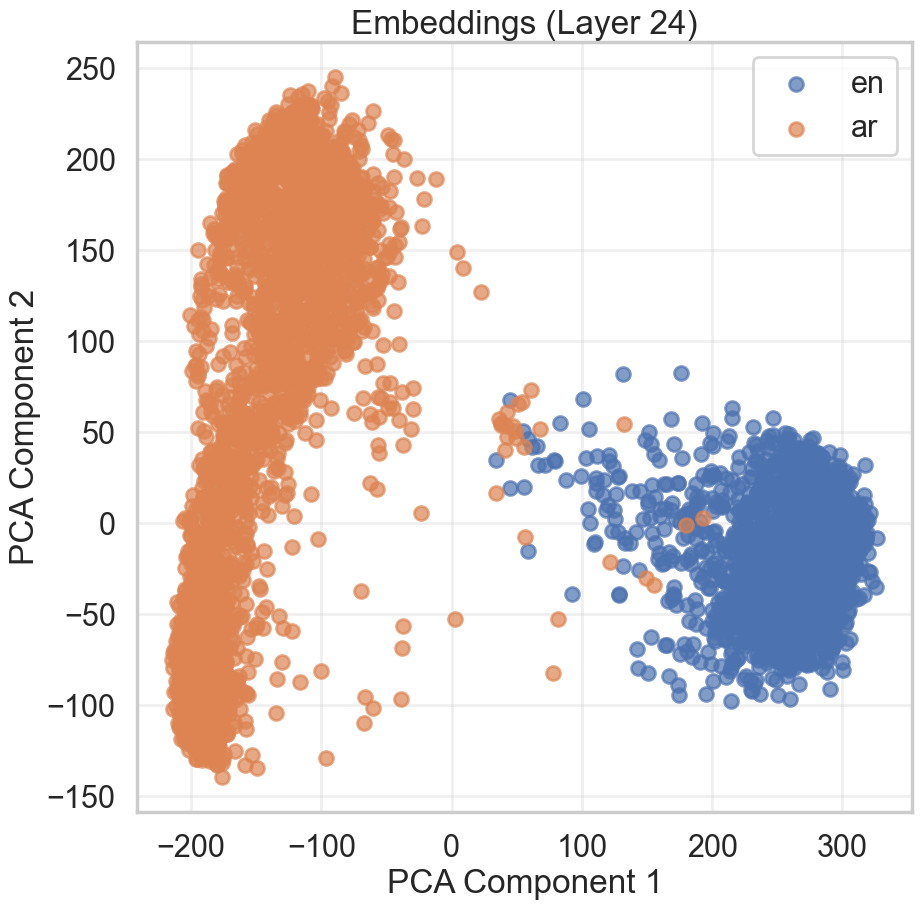

In [ ]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "arb_Arab"], {"eng_Latn": "en", "arb_Arab": "ar"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)

# Multi


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


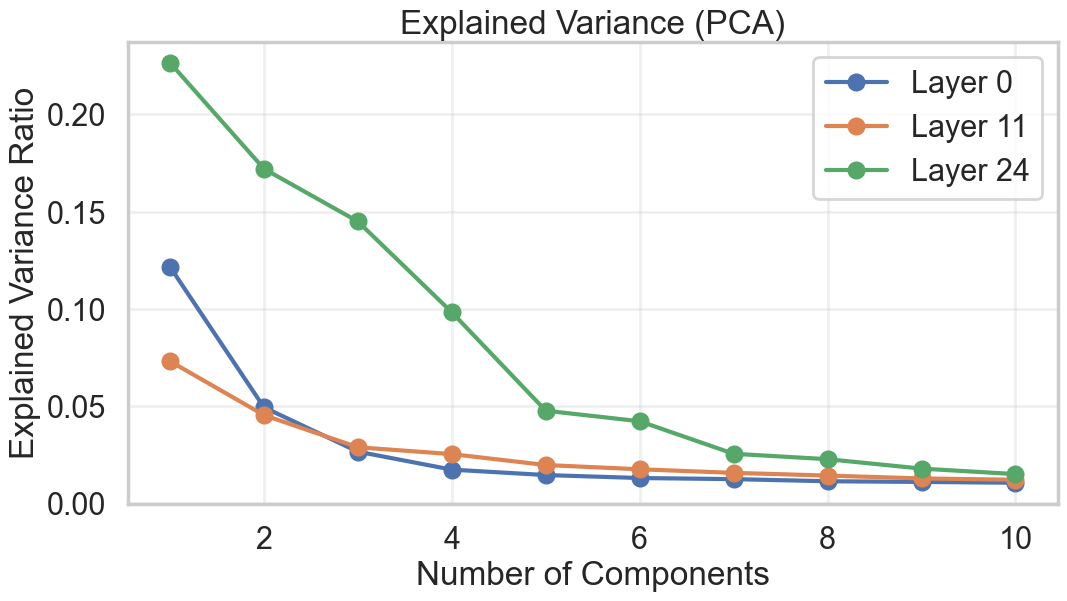

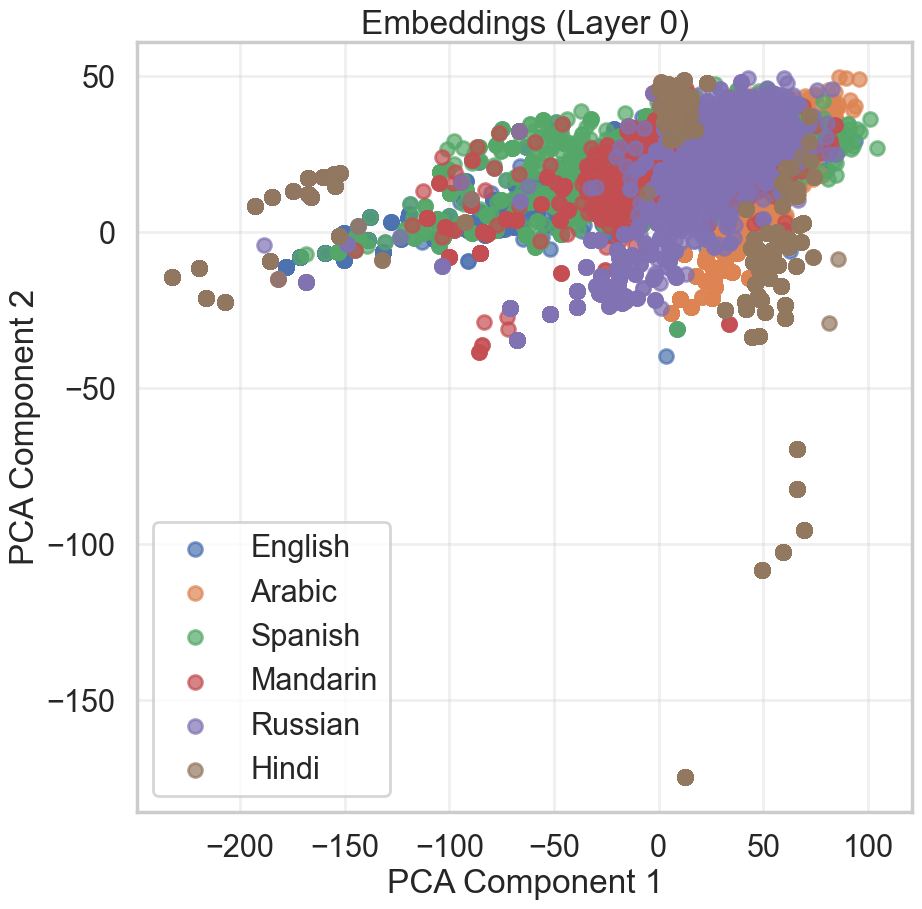

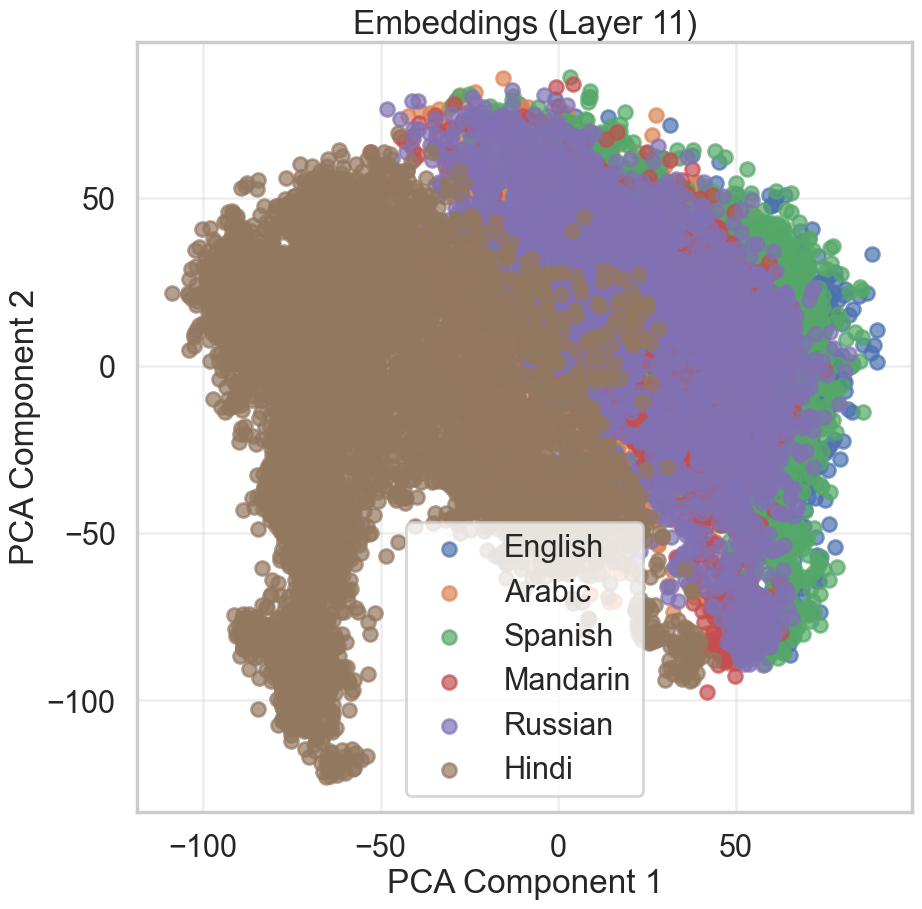

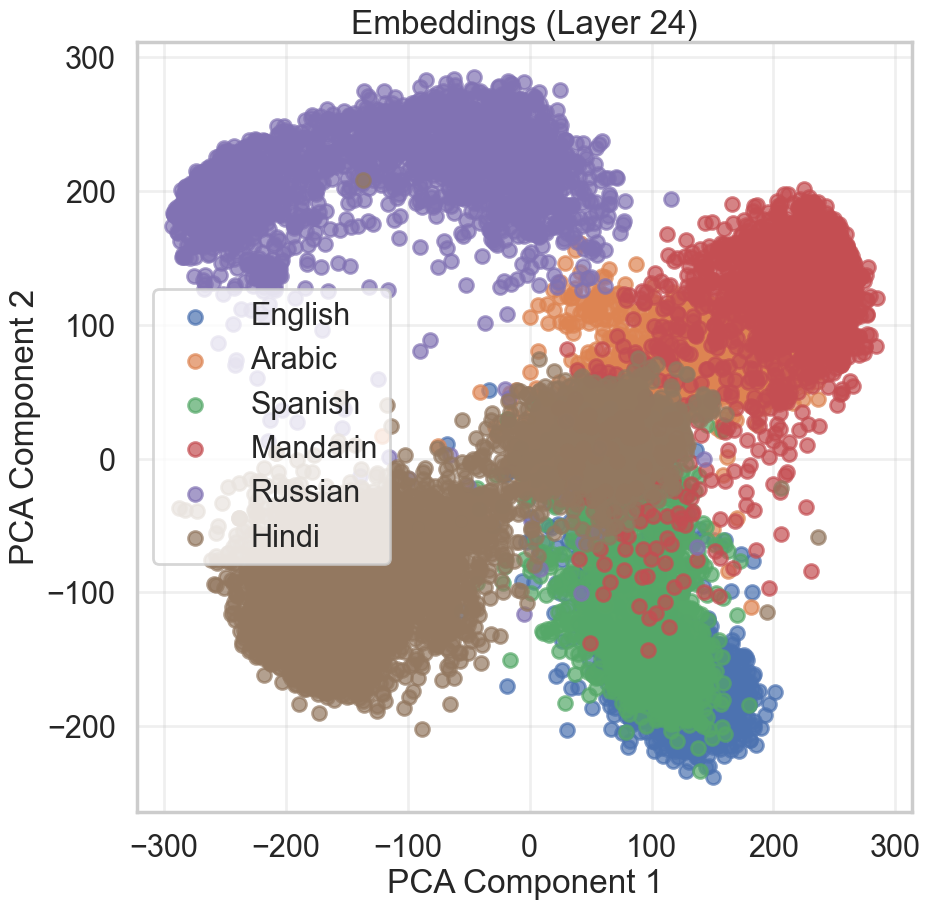

Data len:  100


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


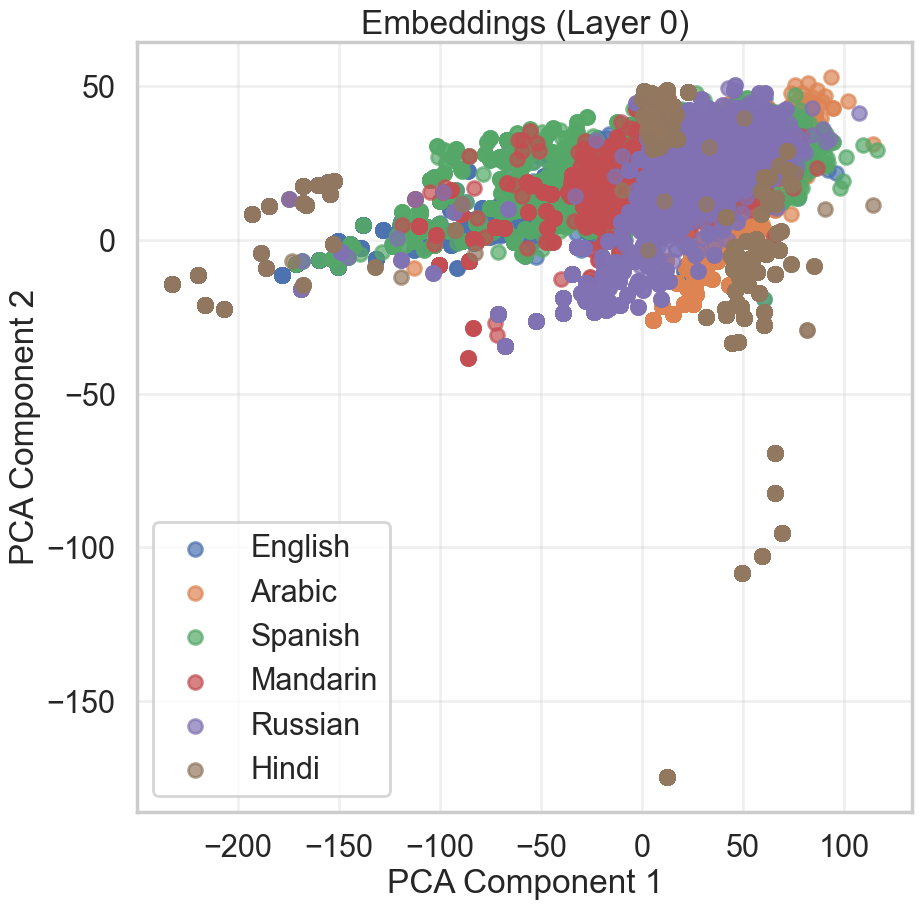

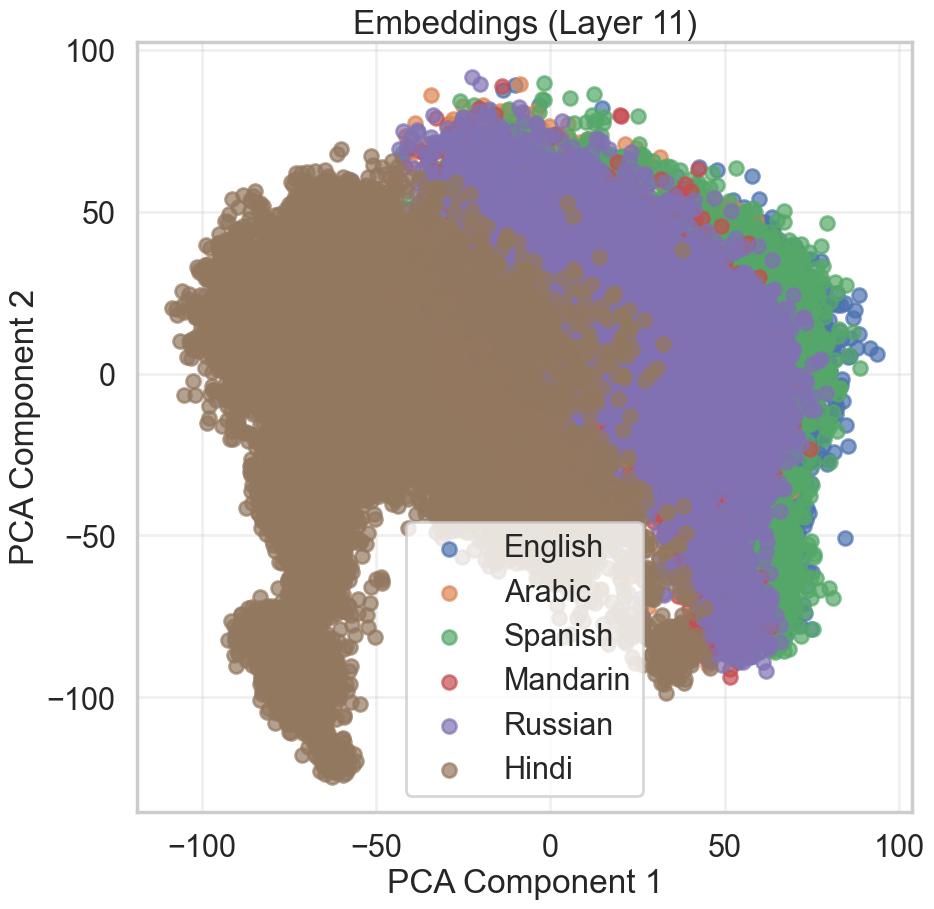

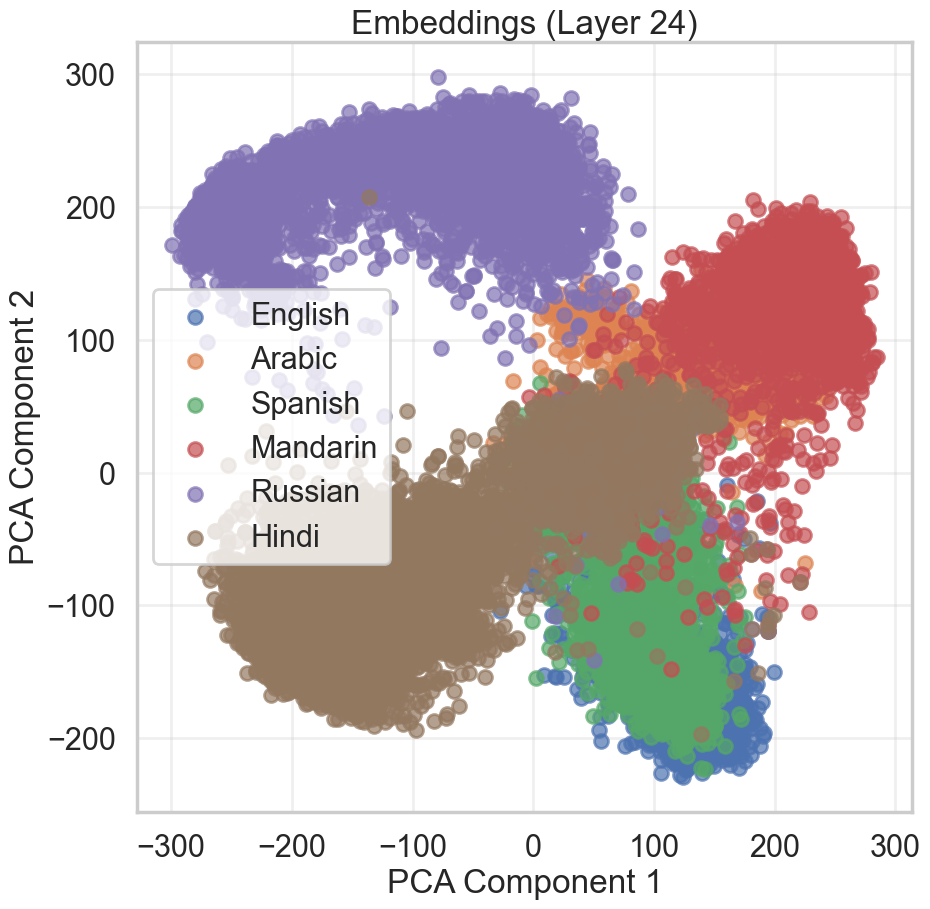

In [ ]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(
    ["eng_Latn", "arb_Arab", "spa_Latn", "cmn_Hans", "rus_Cyrl", "hin_Deva"],
    {
        "eng_Latn": "English",
        "arb_Arab": "Arabic",
        "spa_Latn": "Spanish",
        "cmn_Hans": "Mandarin",
        "rus_Cyrl": "Russian",
        "hin_Deva": "Hindi",
    },
    train_size=50,
)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)